# Estudio de regresión lineal univariable de estadísticas de NBA de varios equipos en varias temproadas

## Parte 1

### Discusión del modelo de datos

La tabla Excel que se nos presenta consta de las columnas (Team,Season, W, L, WIN%, etc. Las leyendas de estos atributos se ven más abajo. En una primera observación el modelo resultante de esta tabla podría realizarse de varias formas. En este documento voy a utilizar un modelo relacional para poder ser utilizado con SQL. Pero podemos utilizar otros noSQL con idéntico resultado.

Podemos reformular la especificación como en la NBA existen varios equipos los cuales participan cada uno en varias temporadas obteniendo unas estadísticas en cada una de estas temporadas. En cada temporada participan varios equipos. Como entidades podemos decir que están los Equipos (Teams) y las Temporadas (Seasons). Podríamos establecer que Estadísticas es otra entidad en la cual para cada equipo en una temporada tendría unas estadisticas. Esto es debido a que Estadísticas podría ser una entidad por el número de atributos que tendría. Voy a implementar directamente el modelo relacional que sería el DDL para esta base de datos.



Pero también podríamos simplificarlo y que sea una relación. Con lo cual tendríamos una relación: Teams (1,n) <--->  Seasons (1..n). Lo de hacer una ternaria nos llevaría a sacar una tabla por cada entidad: Teams, Seasons, Stats y luego la tabla de la relación Equipo_tiene_estadísticas_en_temporada(id, idteams(fk), idseasons(fk), stats(fk)) y las tablal Teams(idteams, teamname, conference, ...), luego Seasons(idseason, years), y por último Stats(idstat, W, L, W%, ...). Cabe decir que la Tabla Stats también podría ser dividida ya que podemos establecer estadísticas de tiro, rebote, etc. Pero eso sería una jerarquia que como opción podríamos incluirlo todo en esta tabla. 

Voy a elegir realizar una relación binaria y dejar stats como relación con varios atributos. De esta forma saldrían dos tabla para Teams y Seasons y una tercera tabla que sería Tiene_Estadísticas(idTeams(pk,fk), idSeason(pk,fk), W, L, W%...). Ahorras una tabla aunque tal vez pierdas algo de semántica, pero las queries pueden ser más simples.

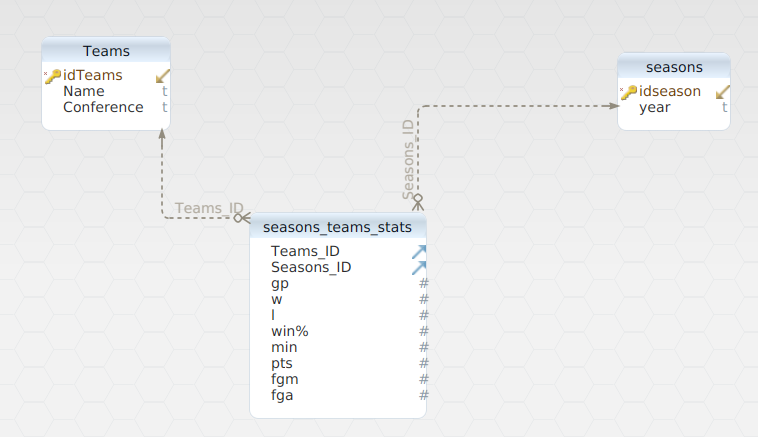

CREATE SCHEMA nba1;

CREATE TABLE nba1.`Teams` ( 
	`idTeams`            int  NOT NULL    PRIMARY KEY,
	`Name`               varchar(100)      ,
	`Conference`         enum(E,N,NE,W,S)      
 );

CREATE TABLE nba1.seasons ( 
	idseason             int  NOT NULL    PRIMARY KEY,
	year                 varchar(50)      
 );

CREATE TABLE nba1.seasons_teams_stats ( 
	`Teams_ID`           int      ,
	`Seasons_ID`         int      ,
	gp                   decimal(3,2)      ,
	w                    decimal(3,2)      ,
	l                    decimal(3,2)      ,
	`win%`               decimal(3,5)      ,
	min                  decimal(3,2)      ,
	pts                  decimal(3,4)      ,
	fgm                  decimal(3,5)      ,
	fga                  decimal(3,5)      ,
	CONSTRAINT `Fk_Seasons_Teams1` FOREIGN KEY ( `Teams_ID` ) REFERENCES nba1.`Teams`( `idTeams` ) ON DELETE NO ACTION ON UPDATE NO ACTION,
	CONSTRAINT `Fk_Seasons_Teams2` FOREIGN KEY ( `Seasons_ID` ) REFERENCES nba1.seasons( idseason ) ON DELETE NO ACTION ON UPDATE NO ACTION
 );

CREATE TABLE nba1.stats ( 
	idstat               int  NOT NULL    PRIMARY KEY
 );


In [1]:
import pandas as pd
# Instalamos el openpyxl, para los notebooks de navegador podría ser necesario, no así para los de Spyder
import sys
!{sys.executable} -m pip install openpyxl 

In [2]:
# En un primer y por motivos de simplicidad vamos extraer la información del fichero excel a un dataset utilizando 
# el engine openpyxl para excel nuevos
df1 = pd.read_excel('nbaData.xlsx',engine='openpyxl')

FileNotFoundError: [Errno 2] No such file or directory: 'nbaData.xlsx'

In [ ]:
# Quitamos las columnas NaN
df2 = df1.dropna(axis=1)

In [ ]:
# Aquí las leyendas de las columnas a las que nos referiremos para evaluar la estadística

#GP Games Played W Wins L Losses 
#WIN% Win Percentage 
# MIN Minutes Played 
#FGM Field Goalds Made 
#FGA Field Goals Attempted 
#FG% Field Goal Percentage 
#3PM 3 Point Field Goals Made 
#3PA 3 Point Field Goals Attempted 
#3P% 3 Point Field Goals Percentage 
#FTM Free Throws Made 
#FTA Free Throws Attempted 
#FT% Free Throw Percentage 
#OREB Offensive Rebounds 
#DREB Defensive Rebounds 
#REB Rebounds 
#AST Assists 
#TOV Turnovers 
#STL Steals 
#BLK Blocks 
#BLKA Blocked Field Goal Attempts 
#PF Personal Fouls 
#PFD Personal Fouls Drawn 
#PTS Points 
#+/- Plus Minus 

In [ ]:
df2.columns


In [ ]:
# De la misma forma instalamos sqlalchemy, un paquete que nos ayudará mucho a utilizar bases de datos
!{sys.executable} -m pip install sqlalchemy

In [ ]:
# Vamos a utilizar sqlite pero podemos utilizar un engine para postgre, mysql, oracle, etc.
from sqlalchemy import create_engine
engine = create_engine('sqlite://', echo=False)
df2.to_sql('stats',con=engine,index=False)

In [ ]:
st1 = engine.execute("SELECT * FROM STATS").fetchall()


In [ ]:
eng1 = engine.execute("SELECT * FROM STATS group by team").fetchall()


In [ ]:
df3 = pd.read_sql_table(table_name='stats',con=engine)
#pd.set_option('display.max_rows',150)
#pd.set_option('display.max_columns',30)
#df3

In [ ]:
import numpy as np

In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt

In [ ]:
#df3.hist(bins=50,figsize=(20,15))
#df3

In [ ]:
!{sys.executable} -m pip install seaborn
import seaborn as sb
#sb.regplot(x="W", y="FGM",data=df3, scatter=True, 
#           color="r", ci=70)
#plt.title("regression")
#plt.show()

#sb.regplot(x="W", y="FT%",data=df3, scatter=True,
#           color="r", ci=70)
#plt.title("regression")
#plt.show()


In [ ]:
sb.pairplot(df3, 
             x_vars = ['AST', 'TOV', 'STL', 'BLK', 'BLKA'], 
             y_vars = ['WIN%'], kind = 'reg')
sb.pairplot(df3, x_vars=['PF', 'PFD', '+/-','MIN', 'PTS'],
           y_vars=["WIN%"], kind="reg")
sb.pairplot(df3, x_vars=['FGM', 'FGA',
       'FG%', '3PM', '3PA', '3P%'],
           y_vars=["WIN%"], kind="reg")
sb.pairplot(df3, x_vars=['FTM', 'FTA', 'FT%', 'OREB', 'DREB', 'REB'], y_vars=["WIN%"], kind="reg")

In [ ]:
nuevo = df3[['WIN%', 'MIN', 'PTS', 'FGM', 'FGA',
       'FG%', '3PM', '3PA', '3P%', 'FTM', 'FTA', 'FT%', 'OREB', 'DREB', 'REB',
       'AST', 'TOV', 'STL', 'BLK', 'BLKA', 'PF', 'PFD', '+/-']]

In [ ]:
sb.set_style("ticks")
plt.figure('paper',figsize=(8,4))
sb.pairplot(y='+/-',x='WIN%',data=nuevo,kind="reg")
sb.jointplot(y='FG%',x='WIN%',data=nuevo,kind="reg")
sb.jointplot(y='BLKA',x='WIN%',data=nuevo,kind="reg")

In [ ]:
sb.heatmap(nuevo)